# Application empirique double selection: effet du niveau de diplôme sur le salaire (données enquête emploi)

Jérémy L'Hour

Modifié le 09/06/2020

In [2]:
rm(list=ls())

### CHARGEMENT DES PACKAGES
#library('aws.s3')
library('haven')
library('glmnet')
library('ggplot2')
library('fastDummies') # pour créer des dummies à partir de catégories
library('caret') # pour utiliser la fonction qui repère les variables colinéaires
library('foreach') # utile pour calculer les ecarts-types clusterisés
library('doParallel')
# library('grplasso') # pour group-lasso, mais solution hyper longue

### Fonctions faites maison
source('functions/group_lasso.R') # Algorithme de calcul du group lasso, plus rapide que le package ici
source('functions/K_matrix_cluster.R')

Loading required package: Matrix

Loaded glmnet 3.0-2


Loading required package: lattice

Loading required package: iterators

Loading required package: parallel



In [3]:
#######################
#######################
### DATA MANAGEMENT ###
#######################
#######################

load("/Users/jeremylhour/Documents/data/data_use.Rda") # loading pre-processed data

### Mise en place des bonnes matrices
names_continuous = c("AG", "AG_2", "ANCENTR","HHC","NBENFIND")
names_categorical = c("SEXE","APPDIP","SANTGEN","ADMHAND","CATAU2010", "CHPUB","CHRON",
                      "COMSAL","COURED","CSPM","CSPP","FORDAT","DESC","IMMI","DUHAB","ENFRED","SPE",
                      "MAISOC","MATRI","NAT14","NBAGEENFA","NBENFA1","NBENFA10","NBENFA15","NBENFA18","QP","REG","SO","SOIRC","TYPMEN21")

outcome = "LOG_SAL"
X_1_names = "DIP"
X_2_names = c(names_continuous,names_categorical)

# "Y" (outcome)
Y = data_use[,outcome]

# "X_1" (variables d'intérêt)
X_1 = model.matrix(~. - 1, data = data.frame("EDUC"=as.factor(data_use[,X_1_names])), contrasts.arg = "EDUC")
X_1 = X_1[,1:(ncol(X_1)-1)] # On enlève la modalité "sans diplôme" pour éviter les problèmes de colinéarité.

# "X_2" (contrôles)
one_hot_category = dummy_cols(data_use[,names_categorical], remove_most_frequent_dummy=TRUE, remove_selected_columns=TRUE) # on transforme les variables catégorielles en variables binaires
X_2 = as.matrix(cbind(data_use[, names_continuous], one_hot_category))
X_2 = X_2[,!duplicated(t(X_2))] # On enlève les colonnes dupliquées
colinear = caret::findLinearCombos(cbind(X_1,X_2,rep(1,nrow(X_2)))) 
suppr = colinear$remove-ncol(X_1) # recalage par rapport à l'indice de X_2
X_2 = X_2[,-suppr] # On enlève les colonnes qui créent de la multicolinéairité, avec l'inclusion de X_1 et une constante

# Identifiants clustering
ID_menage = data_use[,"IDENT"] # Identifiant du ménage, pour cluster dans les écart-types.
ID_indiv = paste(data_use[,"IDENT"],data_use[,"NOI"],sep="_") # Identifiant individu.

coef_names = paste("X_1",colnames(X_1),sep="")
n = nrow(X_2); p = ncol(X_2)

#remove(data_use, one_hot_category)

Warning message in model.matrix.default(~. - 1, data = data.frame(EDUC = as.factor(data_use[, :
“non-list contrasts argument ignored”


In [4]:
#################################################
#################################################
### ETAPE 0: Régressions simples et complètes ###
#################################################
#################################################

### Régression simple, sans variables de contrôle
reg_simple = lm(Y ~ X_1)
summary(reg_simple)
tau_simple = reg_simple$coefficients[coef_names]


Call:
lm(formula = Y ~ X_1)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5418 -0.2252  0.0492  0.3049  3.5817 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.070915   0.004099 1725.23   <2e-16 ***
X_1EDUC10    0.770686   0.006169  124.94   <2e-16 ***
X_1EDUC12    0.884981   0.006994  126.53   <2e-16 ***
X_1EDUC21    0.470881   0.006704   70.24   <2e-16 ***
X_1EDUC22    0.684134   0.008440   81.06   <2e-16 ***
X_1EDUC30    0.496945   0.013586   36.58   <2e-16 ***
X_1EDUC31    0.499468   0.005682   87.90   <2e-16 ***
X_1EDUC32    0.428029   0.017900   23.91   <2e-16 ***
X_1EDUC33    0.523129   0.009079   57.62   <2e-16 ***
X_1EDUC41    0.226580   0.007241   31.29   <2e-16 ***
X_1EDUC42    0.321168   0.007053   45.53   <2e-16 ***
X_1EDUC43    0.235983   0.006500   36.30   <2e-16 ***
X_1EDUC44    0.260177   0.009412   27.64   <2e-16 ***
X_1EDUC50    0.225045   0.004906   45.87   <2e-16 ***
X_1EDUC60    0.082923   0.007429   11.16   <2e-16 **

In [7]:
### Régression complète
reg_full = lm(Y ~ X_1 + X_2)
tau_full = reg_full$coefficients[coef_names]
sigma_full = summary(reg_full)$coefficients[coef_names, 2]

### Calcul des écart-types clusterisés
X_2_tilde = cbind(X_2,rep(1,nrow(X_2))) # On ajoute la constante pour faire la régression partielle
FS_residuals = X_1 - X_2_tilde%*%solve(t(X_2_tilde)%*%X_2_tilde)%*%(t(X_2_tilde) %*% X_1)

K_matrix_full = K_matrix_cluster(eps=sweep(FS_residuals,MARGIN=1,reg_full$residuals,`*`), cluster_var=ID_menage, df_adj=ncol(X_2)+ncol(X_1)+1) # cluster au niveau du ménage
J_matrix_full = t(FS_residuals)%*%FS_residuals / n
sigma_full_cluster = sqrt(solve(J_matrix_full) %*% K_matrix_full %*% solve(J_matrix_full)) / sqrt(n) 
sigma_full_cluster = diag(sigma_full_cluster)

print("Résultats du modèle complet")
print(cbind(coef_names,tau_full,sigma_full_cluster))

[1] "Computing clustered standard errors..."
Time difference of 2.447429 mins
[1] "Résultats du modèle complet"
          coef_names  tau_full            sigma_full_cluster  
X_1EDUC10 "X_1EDUC10" "0.597976870405996" "0.0607107737604301"
X_1EDUC12 "X_1EDUC12" "0.608191201584373" "0.0606227244544143"
X_1EDUC21 "X_1EDUC21" "0.434871084763473" "0.0607000731846031"
X_1EDUC22 "X_1EDUC22" "0.497813997443932" "0.0608599111234507"
X_1EDUC30 "X_1EDUC30" "0.390319227753097" "0.0612578694619652"
X_1EDUC31 "X_1EDUC31" "0.379297906890069" "0.0605965369559789"
X_1EDUC32 "X_1EDUC32" "0.369840146380049" "0.0606512824758584"
X_1EDUC33 "X_1EDUC33" "0.442444605372476" "0.0607952029015128"
X_1EDUC41 "X_1EDUC41" "0.285869015989514" "0.061563214536341" 
X_1EDUC42 "X_1EDUC42" "0.268674392146728" "0.0606758425660614"
X_1EDUC43 "X_1EDUC43" "0.280349626320372" "0.0606047535398131"
X_1EDUC44 "X_1EDUC44" "0.269462390890711" "0.0606674848375221"
X_1EDUC50 "X_1EDUC50" "0.214336901724112" "0.0605708395938158"
X_1EDU

In [9]:
############################################
############################################
### ETAPE 1: Selection par rapport à "Y" ###
############################################
############################################

# Il s'agit d'une régression Lasso classique
gamma_pen = .1/log(max(p,n))
lambda    = 1.1*qnorm(1-.5*gamma_pen/p)/sqrt(n) # niveau (theorique) de penalisation Lasso

outcome_selec = glmnet(X_2,Y,family="gaussian",alpha=1,lambda=lambda)
predict(outcome_selec,type="coef")

set_Y = unlist(predict(outcome_selec,type="nonzero")) # ensemble des coefficients non nuls à cette étape

naive_reg = lm(Y ~ X_1 + X_2[,set_Y]) # Naive regression
tau_naive = naive_reg$coefficients[coef_names]

394 x 1 sparse Matrix of class "dgCMatrix"
                         s0
(Intercept)    6.5417271170
AG             0.0042681524
AG_2           .           
ANCENTR        0.0006723615
HHC            0.0169363450
NBENFIND       0.0080161283
SEXE_1         0.0745724379
APPDIP_       -0.1672714666
APPDIP_1      -0.0234390585
SANTGEN_       .           
SANTGEN_1      0.0105822768
SANTGEN_3     -0.0010652256
SANTGEN_4     -0.0038998238
SANTGEN_5      .           
SANTGEN_8      .           
SANTGEN_9      .           
ADMHAND_1     -0.0559282066
ADMHAND_2      .           
ADMHAND_8      .           
ADMHAND_9      .           
CATAU2010_112  .           
CATAU2010_120  .           
CATAU2010_211  .           
CATAU2010_212  .           
CATAU2010_221 -0.0064472501
CATAU2010_222  .           
CATAU2010_300 -0.0411916498
CATAU2010_400 -0.0010126611
CHPUB_         .           
CHPUB_2        0.0329046393
CHPUB_3        .           
CHPUB_4       -0.0387200040
CHPUB_5        .           
CHPUB

In [10]:
##################################################################
##################################################################
### ETAPE 2: Selection par rapport à "X_1" avec le group Lasso ###
##################################################################
##################################################################

# Cette seconde étape est plus compliquée: la variable X_1 possèdre plusieurs modalités,
# Il faut donc binariser (les convertir en one-hot) et faire autant de régressions qu'il y a de modalités
# On propose une approche Group-Lasso dans la mesure où l'on suppose que le schéma de sparsité est le même pour toutes ces régressions.
# Cela nécessite de faire des régression empilées et de vectoriser la variable dépendante si on utilise le package grplasso, ce qui est très long.
# Depuis group-lasso implémenté manuellement.
# Pour le Group Lasso il y a donc p groupes de variables

# ajustement de la pénalisation
gamma_pen = .1/log(ncol(X_1)*max(p,n))
lambda    = 1.1*qnorm(1-.5*gamma_pen/(ncol(X_1)*p))/sqrt(n) # niveau (theorique) de penalisation Lasso

### VERSION A: avec le package grplasso -- ATTENTION TRES GOURMAND!
# X_1_vec = matrix(c(X_1), ncol=1)
# X_2_vec =  kronecker(diag(ncol(X_1)), X_2) # ATTENTION: Prend 8.5 Go de mémoire minimum...
# group_index = rep(1:p,ncol(X_1))
# 
# immunization_selec = grplasso(X_2_vec, X_1_vec, group_index, lambda=n*lambda, model=LinReg()) # ici la fonction objectif est differente, il faut multiplier la penalité par n
# Gamma_hat = matrix(immunization_selec$coefficients, ncol=ncol(X_1))
# row.names(Gamma_hat) = colnames(X_2)

La version ci-dessus utilise le package grplasso. Cela contraint à vectoriser les matrices et prend énormément de place inutile (qui se mesure en Go, 8.5 Go dans une version précédente qui contenait 12 fois moins d'observations). L'utiliser n'est pas recommandé. On a recodé un algorithme FISTA pour calculer la solution Group-Lasso.

In [11]:
### VERSION B: avec implémentation manuelle -- bien plus rapide, moins consommateur en mémoire
immunization_selec_man = group_lasso(X_2,X_1,lambda=lambda,trace=TRUE)
Gamma_hat = immunization_selec_man$beta[-p-1,]

set_X1 = c(which(apply(Gamma_hat>0,1,sum)>0))

[1] "Computing Group-Lasso solution..."
[1] "Objective Func. Value at iteration 100 : 0.0535458623106038"
[1] "Objective Func. Value at iteration 200 : 0.0530183829630149"
[1] "Objective Func. Value at iteration 300 : 0.0526356627830493"
[1] "Objective Func. Value at iteration 400 : 0.0525330180527467"
Time difference of 37.40386 mins


In [12]:
###############################################
###############################################
### ETAPE 3: Estimateur de double sélection ###
###############################################
###############################################

S_hat = sort(union(set_Y,set_X1))
dbs_reg = lm(Y ~ X_1 + X_2[,S_hat])
tau_hat = dbs_reg$coefficients[coef_names]

### Calcul de l'écart-type clusterisé
S_hat = c(S_hat,ncol(X_2_tilde)) # ajouter la constante pour le calcul du Post-Lasso
Gamma_hat = solve(t(X_2_tilde[,S_hat])%*%X_2_tilde[,S_hat]) %*% (t(X_2_tilde[,S_hat]) %*% X_1) # Regression post-lasso de chaque modalités de X_1, on utilise un Ridge pour régulariser
treat_residuals = X_1 - X_2_tilde[,S_hat] %*% Gamma_hat

K_matrix = K_matrix_cluster(eps=sweep(treat_residuals,MARGIN=1,dbs_reg$residuals,`*`), cluster_var=ID_menage, df_adj=ncol(X_1) + length(S_hat) + 1) # cluster au niveau du ménage
J_matrix = t(treat_residuals)%*%treat_residuals / n
sigma = sqrt(solve(J_matrix) %*% K_matrix %*% solve(J_matrix)) / sqrt(n) 

[1] "Computing clustered standard errors..."
Time difference of 2.528978 mins


In [15]:
#################################
#################################
### COMPILATION DES RESULTATS ###
#################################
#################################

dip = data.frame("ID" = c("10","12","22","21","30","31","32","33","41","42","43","44","50","60","70"),
            "Diplome" = c("Master (recherche ou professionnel), DEA, DESS, Doctorat",
              "Ecoles niveau licence et au-delà",
              "Maîtrise (M1)",
              "Licence (L3)",
              "DEUG",
              "DUT, BTS",
              "Autre diplôme (niveau bac+2)",
              "Paramédical et social (niveau bac+2)",
              "Baccalauréat général",
              "Bac technologique",
              "Bac professionnel",
              "Brevet de technicien, brevet professionnel",
              "CAP, BEP",
              "Brevet des collèges",
              "Certificat d'études primaires"),
            "lower_bound" = tau_hat + qnorm(0.025)*diag(sigma),
            "Coefficient" = tau_hat,
            "upper_bound" = tau_hat + qnorm(0.975)*diag(sigma),
            "Moyenne" = tau_simple,
            "Naive" = tau_naive,
            "Full" = tau_full,
            "Full_lb" = tau_full + qnorm(0.025)*sigma_full_cluster,
            "Full_ub" = tau_full + qnorm(0.975)*sigma_full_cluster)

print(dip[,c("Diplome","Coefficient","lower_bound","upper_bound")])


                                                           Diplome  Coefficient
X_1EDUC10 Master (recherche ou professionnel), DEA, DESS, Doctorat  0.496217834
X_1EDUC12                         Ecoles niveau licence et au-delà  0.529028627
X_1EDUC21                                            Maîtrise (M1)  0.296715499
X_1EDUC22                                             Licence (L3)  0.367340926
X_1EDUC30                                                     DEUG  0.236162750
X_1EDUC31                                                 DUT, BTS  0.277161080
X_1EDUC32                             Autre diplôme (niveau bac+2)  0.258830143
X_1EDUC33                     Paramédical et social (niveau bac+2)  0.345060049
X_1EDUC41                                     Baccalauréat général  0.121517635
X_1EDUC42                                        Bac technologique  0.150677892
X_1EDUC43                                        Bac professionnel  0.184203774
X_1EDUC44               Brevet de techni

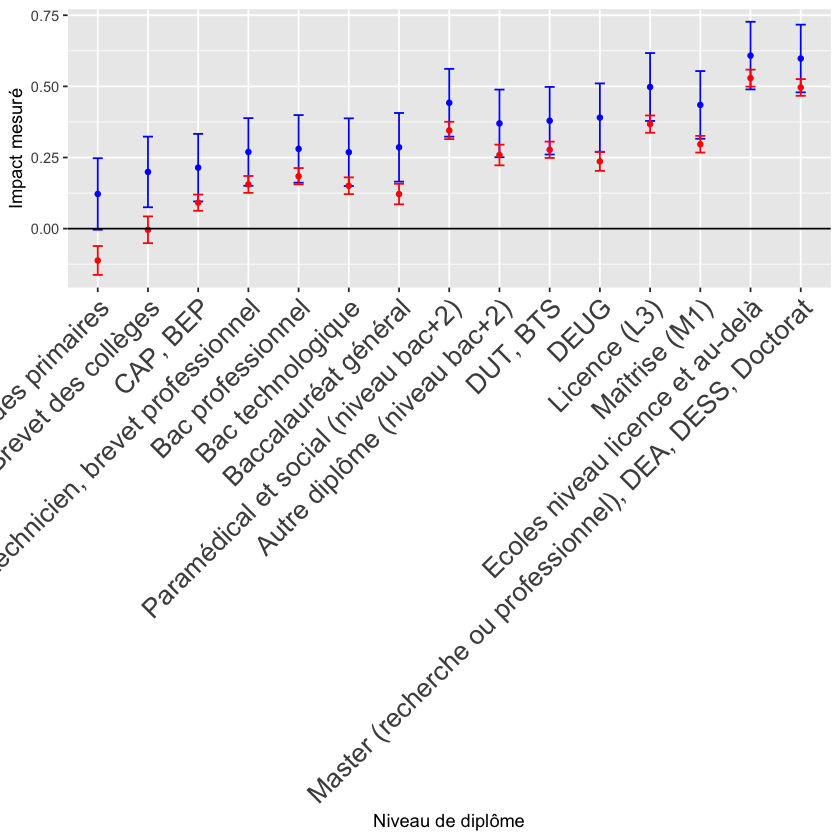

In [16]:
#################
#################
### GRAPHIQUE ###
#################
#################



dodge = position_dodge(.7)

ggplot(data=dip, aes(x = Diplome, y = Full, group=ID)) +
  geom_point(color="blue",fill="blue",shape=16) +
  geom_errorbar(aes(ymin  = Full_lb, ymax  = Full_ub, width = 0.2), color="blue") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=16)) +
  scale_x_discrete(limits=rev(dip$Diplome)) +
  geom_point(aes(x = Diplome, y = Coefficient, group=ID), color="red",fill="red",shape=16, position = dodge) +
  geom_errorbar(aes(ymin  = lower_bound, ymax  = upper_bound, group=ID, width = 0.2), color = "red", position = dodge) +
  geom_abline(slope=0,intercept=0) +
  labs(x = "Niveau de diplôme", y = "Impact mesuré")

Le graphique ci-dessus donne, pour chaque modalité de la variable "diplôme", l'estimateur et l'intervalle de confiance à 95% selon deux méthodes: une méthode brutale où toutes les variables de contrôle sont ajoutées au modèle et la méthode de double-sélection. On constate que la méthode de la double-sélection permet un gain de précision important. L'effet mesuré avec la méthode de double-sélection est également moindre en terme de magnitude.